In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from IPython.display import Markdown

In [6]:
tstr = ""
tstr += f"n | n! | $F_n$ | Absolute Error | Relative error\n"
tstr += f"---|---|---|---|---|\n"
for n in range(1,21):
    tstr+= f"{n} |  {fact(n)} | {fact_approx(n)} | {np.abs(fact_approx(n)- fact(n))} | {np.abs(fact_approx(n)- fact(n))/fact(n)}\n"
display(Markdown(tstr))

NameError: name 'fact' is not defined

In [7]:
def solve_tridiagonal_system(T,b):
    x = np.zeros_like(b)
    n = T.shape[0]
    T = T.copy() 
    b = np.copy(b)
    for i in range(1,n):
        T[i,i] = T[i,i] - T[i-1,i]*(T[i,i-1]/T[i-1,i-1])
        b[i] = b[i] -  b[i-1] *(T[i,i-1]/T[i-1,i-1])
    x[n-1] = b[n-1]  /T[n-1,n-1]
    for i in range(n-2,-1,-1):
        x[i] = (b[i] - x[i+1]*T[i,i+1])/T[i,i]
    return x

## Question 1

In [8]:
f_1 = lambda x: np.sin(np.pi*x)**3

In [9]:
def calculate_lagrange_weights(x_points):
    n = len(x_points)
    w = np.zeros(n)
    for i in range(n):
        w[i] = np.prod(1./np.array([x_points[i] - x_points[j] for j in range(n) if j != i]))
    return w

In [10]:
def evaluate_lagrange(x_points,y_points, w, x):
    n = len(x_points)
    f = np.dot(w/(x-x_points), y_points)/ np.sum(w/(x-x_points))
    if np.isnan(f):
        f = f_1(x)
    return f 

/tmp/ipykernel_98483/3434835620.py:3: RuntimeWarning: divide by zero encountered in divide
  f = np.dot(w/(x-x_points), y_points)/ np.sum(w/(x-x_points))
/tmp/ipykernel_98483/3434835620.py:3: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(w/(x-x_points), y_points)/ np.sum(w/(x-x_points))


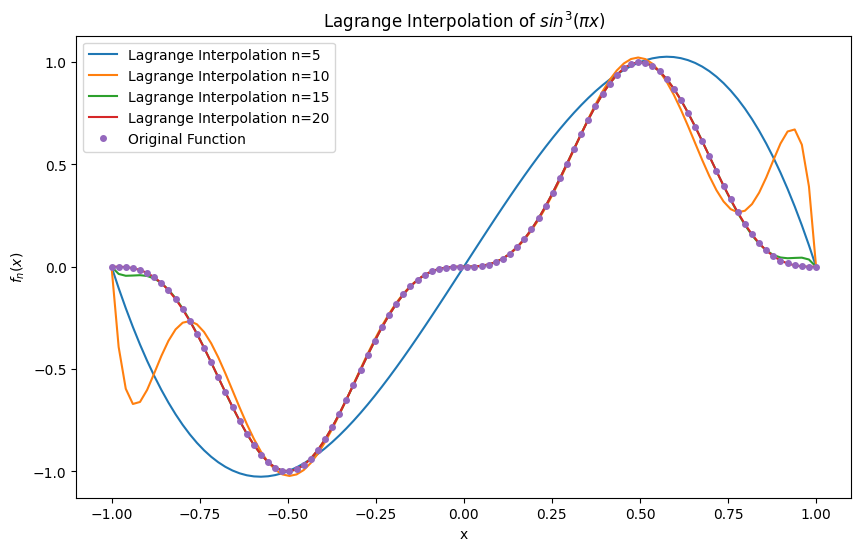

In [276]:
limits = [-1.,1.]
plt.figure(figsize=(10, 6))
for n in [5,10,15,20]:
    x_points = np.linspace(limits[0], limits[1], n)
    y_points = f_1(x_points)
    w = calculate_lagrange_weights(x_points)
    x = np.linspace(limits[0], limits[1], 100)
    y = np.zeros_like(x)
    for i,t in enumerate(x):
        y[i] = evaluate_lagrange(x_points, y_points, w, t)
    plt.plot(x, y, label=f'Lagrange Interpolation n={n}')
plt.plot(x, f_1(x),'o',markersize=4 ,label='Original Function')
plt.legend()
plt.title(f'Lagrange Interpolation of $sin^3(\pi x)$')
plt.xlabel('x')
plt.ylabel('$f_n(x)$')
plt.show()

## Question 2

In [230]:
def genTriDiagonalmatrix(n,h):
    x = [[1 for i in range(n-1)],[4 for i in range(n)],[1 for i in range(n-1)]]
    x[1][0],x[1][-1] = 2,2
    A = sp.sparse.diags(x, [-1,0,1])
    A = sp.sparse.csr_array(A).multiply(h)
    return A

In [ ]:
def polyeval(x, *a):
    b=a[-1]
    n = len(a)
    for i in range(2,n+1):
        b = b*x + a[n-i]
    return b

In [285]:
def eval_cubic_spline(x,x_points,a,b,c,d):
    i = np.max((np.argmin(x>x_points) -1 ,0))
    return polyeval(x-x_points[i],a[i], b[i],c[i],d[i])

In [ ]:
f_2 = lambda x : np.cos(x**2)
f_2_ = lambda x : -2*x*np.sin(x**2)

In [292]:
def compute_cubic_spline(a,b,n,f):
    x = np.linspace(a,b,n)
    h = x[1] - x[0]
    A = genTriDiagonalmatrix(n,h)

    b0, bn = f_2_(x[0]),f_2_(x[-1])

    fs  = f(x)

    f_sec = (fs[1:] - fs[:-1])/(x[1:]-x[:-1])

    b = np.zeros(n)

    b[1:-1] = 3*(f_sec[1:]-f_sec[:-1])
    b[0] = 3*(f_sec[0]-b0)
    b[-1] = 3*(bn-f_sec[-1])
    c = solve_tridiagonal_system(A,b)
    b = f_sec - (h/3.) * (c[1:]+2.*c[:-1])
    d = (c[1:]-c[:-1])/(3*h)
    a = f_2(x)[:-1]
    return a,b,c,d

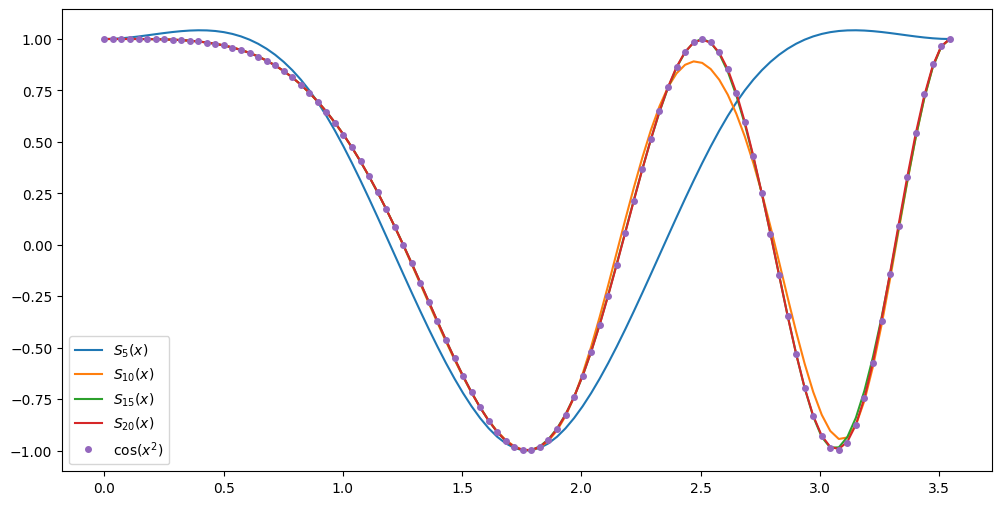

In [304]:
l,u = 0,2*np.sqrt(np.pi)
x_eval = np.linspace(0,2*np.sqrt(np.pi),100) 
fx = np.zeros_like(x_eval)
plt.figure(figsize=(12,6))

for n in [5,10,15,20]:
    x = np.linspace(l,u,n)
    a,b,c,d = compute_cubic_spline(l,u,n,f_2)
    for i in range(x_eval.shape[0]):
        fx[i] = eval_cubic_spline(x_eval[i],x, a,b,c,d)
    plt.plot(x_eval,fx, label = f'$S_{{{n}}}(x)$')
plt.plot(x_eval, f_2(x_eval),'o',markersize= 4,label = f'$\cos(x^2)$')
plt.legend()
plt.show()

## Question 4

In [305]:
#Simpsons rule 
def simpson_integral(f,a,b,n):
    if n%2 == 1:
        n += 1
    h = (b-a)/n
    x = np.linspace(a,b,n+1)
    y = f(x)
    I = h/3*(y[0] + 4*np.sum(y[1:n:2]) + 2*np.sum(y[2:n-1:2]) + y[n])
    return I

In [306]:
def trapezoidal_integral(f,a,b,n):
    h = (b-a)/n
    x = np.linspace(a,b,n+1)
    y = f(x)
    I = h/2*(y[0] + 2*np.sum(y[1:n]) + y[n])
    return I

In [307]:
def midpoint_integral(f,a,b,n):
    h = (b-a)/n
    x = np.linspace(a+h/2,b-h/2,n)
    y = f(x)
    I = h*np.sum(y)
    return I

In [308]:
def gauss_quad(f,a,b):
    pts,wts = np.polynomial.legendre.leggauss(4)
    pts = (b-a)/2*pts + (b+a)/2
    wts = (b-a)/2*wts
    return np.sum(f(pts)*wts)

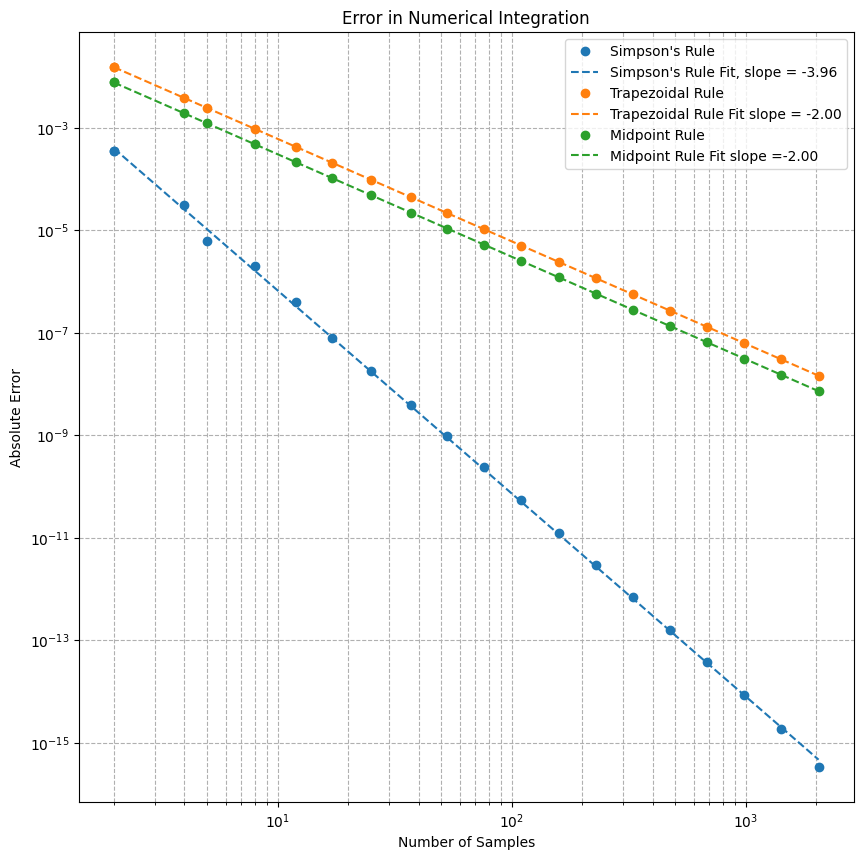

In [ ]:
a,b = 0,1
n = 100
f_3 = lambda x: np.exp(-x**2)
samples = np.logspace(1,11,20,base=2,dtype=int)
true_value = 0.7468241328124271
err1 = []
err2 = []
err3 = []
err4 = []
plt.figure(figsize=(10,10))
for n in samples:
    I1 = simpson_integral(f_3,a,b,n)
    I2 = trapezoidal_integral(f_3,a,b,n)
    I3 = midpoint_integral(f_3,a,b,n)
    # I4 = gauss_quad(f_3,a,b)
    err1.append(np.abs(I1 - true_value))
    err2.append(np.abs(I2 - true_value))
    err3.append(np.abs(I3 - true_value))
    # err4.append(np.abs(I4 - true_value))
a1,b1= np.polyfit(np.log2(samples),np.log2(err1),1)
a2,b2= np.polyfit(np.log2(samples),np.log2(err2),1)
a3,b3= np.polyfit(np.log2(samples),np.log2(err3),1)
plt.loglog(samples,err1,label='Simpson\'s Rule', marker='o',linewidth=0,color='C0')
plt.plot(samples,2**(b1 + a1*np.log2(samples)), label=f'Simpson\'s Rule Fit, slope = {a1:.2f}', linestyle='--', color='C0')
plt.loglog(samples,err2,label='Trapezoidal Rule', marker='o',linewidth=0,color='C1')
plt.plot(samples,2**(b2 + a2*np.log2(samples)), label=f'Trapezoidal Rule Fit slope = {a2:.2f}', linestyle='--',color='C1')
plt.loglog(samples,err3,label='Midpoint Rule', marker='o',linewidth=0,color='C2')
plt.plot(samples,2**(b3 + a3*np.log2(samples)), label=f'Midpoint Rule Fit slope ={a3:.2f}', linestyle='--',color='C2')
# plt.plot(samples,err4,label='Gauss Quadrature', marker='o')
plt.title('Error in Quadrature Integration')
plt.xlabel('Number of Samples')
plt.ylabel('Absolute Error')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.show()